<a href="https://colab.research.google.com/github/Aadhimozhi/DL_Lab/blob/main/exn0_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, datetime, tarfile
import scipy.io

In [ ]:
# Download and extract dataset
url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar"
path = tf.keras.utils.get_file("wiki_crop.tar", origin=url, extract=False)
with tarfile.open(path, "r:") as tar:
    tar.extractall(path=os.path.dirname(path))
data_dir = os.path.join(os.path.dirname(path), 'wiki_crop')

811315200/811315200 ━━━━━━━━━━━━━━━━━━━━ 41s 0us/step


In [ ]:
# Load .mat file and extract age and image paths
mat = scipy.io.loadmat(os.path.join(data_dir, 'wiki.mat'))
dob = np.vectorize(lambda x: datetime.datetime.fromordinal(x).year)(mat["wiki"]["dob"][0][0][0])
age = (mat["wiki"]["photo_taken"][0][0][0] - dob).astype(np.float32)
paths = np.vectorize(lambda x: os.path.join(data_dir, x[0]))(mat["wiki"]["full_path"][0][0][0])

In [ ]:
# Build tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((paths, age))

def preprocess(filename, label):
    img = tf.io.decode_jpeg(tf.io.read_file(filename), channels=1)
    img = tf.image.resize(img, [256, 256])
    return img, tf.expand_dims(label, 0)

dataset = dataset.map(preprocess).shuffle(100).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Split dataset
size = dataset.cardinality().numpy()
train_ds = dataset.take(int(size * 0.6))
val_ds = dataset.skip(int(size * 0.6)).take(int(size * 0.2))
test_ds = dataset.skip(int(size * 0.8))

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 7, activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(256, 1, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - loss: 15.2607 - mae: 15.2607 - val_loss: 13.1233 - val_mae: 13.1233
Epoch 2/3
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - loss: 13.2176 - mae: 13.2176 - val_loss: 11.8097 - val_mae: 11.8097
Epoch 3/3
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 88s 58ms/step - loss: 12.3818 - mae: 12.3818 - val_loss: 11.4877 - val_mae: 11.4877
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 11.5225 - mae: 11.5225
Test MAE: 11.79


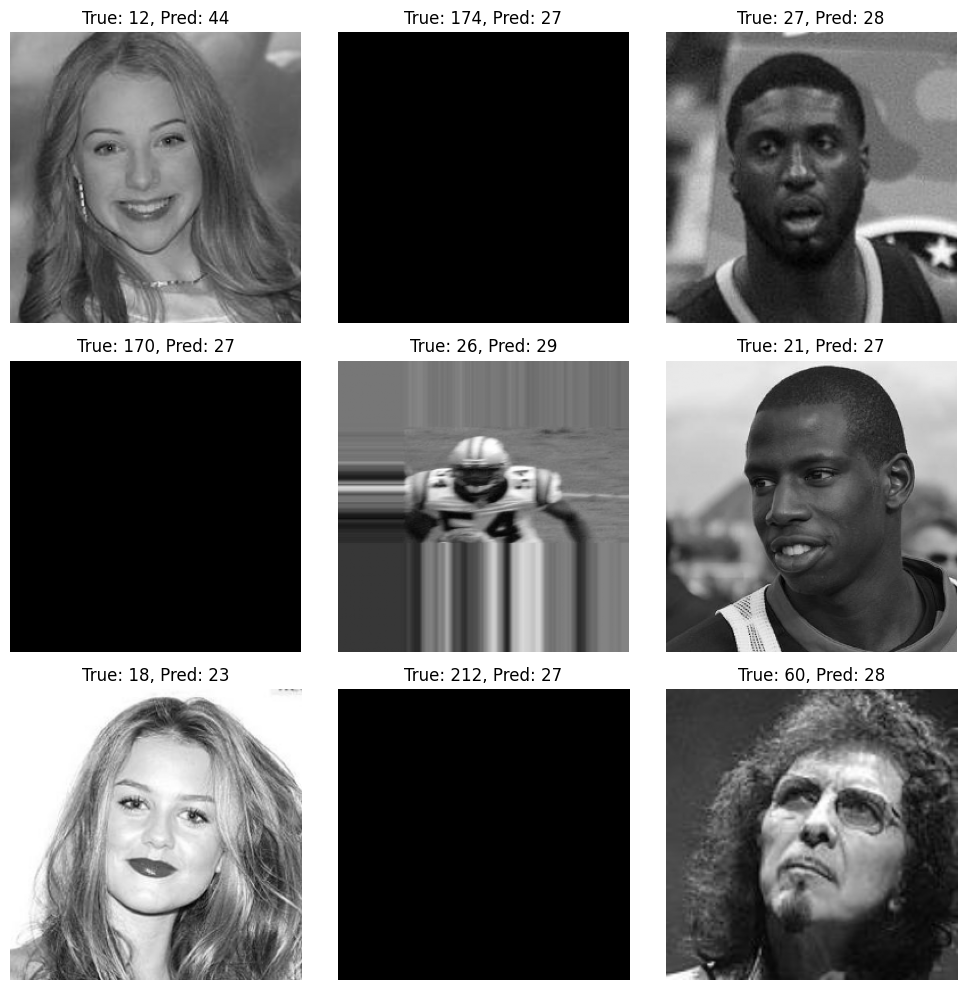

In [ ]:
# Compile and train
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.fit(train_ds, validation_data=val_ds, epochs=3)

# Evaluate
loss, mae = model.evaluate(test_ds)
print(f"Test MAE: {mae:.2f}")

# Visualize predictions
images, labels = next(iter(val_ds))
preds = tf.squeeze(model(images))
labels = tf.squeeze(labels)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(images[i]), cmap='gray')
    plt.title(f"True: {labels[i]:.0f}, Pred: {preds[i]:.0f}")
    plt.axis("off")
plt.tight_layout()
plt.show()